In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
df.shape

(303, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [7]:
df['target'].value_counts(normalize= True, dropna= False)

,proportion
target,
0,0.726073
1,0.273927


**it** is bit imbalanced (its not 50/50)

What's a 'naive' **baseline model** for this problem?

A baseline model would be to just predict a probability of 0.0 for every patient. That will result in 72% accuracy.

Any fancy model we build needs to do better than this

### Preprocessing
  - This dataset has both categorical and numeric variables.
  - it will be convenient (for later preprocessing) to collect these groups of variables into two lists.

In [8]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
numerics = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']

**NN** require all their inputs to be numeric so we will first preprocess this raw data as follows:
- one-hot encode the categorical variables
- normalize the numeric variables

*With the help of pandas `get_dummies` function, you can one-hot-encode in one line*

In [9]:
df = pd.get_dummies(df, columns= categorical_variables, dtype= int)
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,67,160,286,108,1.5,2,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,67,120,229,129,2.6,2,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,37,130,250,187,3.5,3,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41,130,204,172,1.4,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


**NN** work best when the inputs are all roughly in the same range, they shouldn't have a wide range of variation. So standard practice is to **standardize** (*means - substract the mean, divide by the standard deviation*) the numeric variables.
- But before we do so, let's split the data into an 80% training set and 20% test set.
- *why should we spliting now before we do normalization?*


> *Because the test set has now essentially been influenced by the training set. so that test data stays $unknown$.*



In [10]:
test_df = df.sample(frac= 0.2, random_state= 42)
train_df = df.drop(test_df.index)

In [11]:
train_df.shape

(242, 30)

In [12]:
test_df.shape

(61, 30)

Let's calculate the mean and standard deviation of every numeric variable in the training set.

In [13]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [14]:
means

,0
age,54.268595
trestbps,131.995868
chol,246.512397
thalach,149.805785
oldpeak,1.032645
slope,1.590909


In [15]:
sd

,0
age,9.059861
trestbps,18.012789
chol,48.485377
thalach,23.132298
oldpeak,1.169729
slope,0.632783


Let's standardize the train and test dataframes with these means and standard deviations.

In [16]:
train_df[numerics] = (train_df[numerics] - means) / sd
test_df[numerics] = (test_df[numerics] - means) / sd

In [17]:
train_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,0.963746,0.721939,-0.278690,0.008396,1.083461,2.226814,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1.405254,1.554681,0.814423,-1.807247,0.399542,0.646494,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,1.405254,-0.665964,-0.361189,-0.899426,1.339930,0.646494,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,-1.906055,-0.110803,0.071931,1.607891,2.109339,2.226814,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,-1.464547,-0.110803,-0.876809,0.959447,0.314052,-0.933825,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


At this point, data is entirely numeric. we are almost ready to feed it to keras.
- The easiest way to feed data to $Keras$ / $TensorFlow$ is as Numpy arrays, so we convert our dataframe to Numpy arrays.
- And then $Keras$ is happy to take it, happy to receive it.


In [18]:
train = train_df.to_numpy()
test = test_df.to_numpy()

**Final Step:** Our feature $X$ and dependent variable $y$ are both inside ``train`` and ``test`` arrays, so let's seperate them out.

Note that the ``target`` column is our $y$ variable and it is column #6 from the left (counting from 0)

The ```np.delete``` function is perfect for selecting all columns expect one.



In [19]:
train_X = np.delete(train, 6, axis= 1)
test_X = np.delete(test, 6, axis= 1)

In [20]:
train_X.shape, test_X.shape

((242, 29), (61, 29))

^ And now we have 29 features, means 29 nodes in the input layer.

Next, select just the 6th column and define the `train` and `test` $y$ variables.

In [21]:
train_y = train[:, 6]
test_y = test[:, 6]

#### **Let's Build a model**
- Define model in $Keras$


Creating an $NN$ is usually just a few lines of code.

- we will start with a single hidden layer.
- Since this is a binary classification problem, we will use $sigmoid$ activation in the output layer.



In [22]:
num_columns = train_X.shape[1]     # [1] select number of features

# define the input layer
input = keras.Input(shape= (num_columns,))

# feed the input vector to the hidden layer
# optional: you can give names to each layer to help
# keep track. This doesn't affect the training etc.
h =  keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell keras that this (input,output) pair is your model
model = keras.Model(input,output)

The ``model.summary()`` command is a good way to get a quick overview of what you have defined.

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Let's do some hand-calculate to verify number of parameters.

In [24]:
((29 * 16) + 16) + ((16 * 1) + 1)    # ((weights) + bias)

497

We can **visualize** the network graphically as well using Keras ``plot_model`` function.

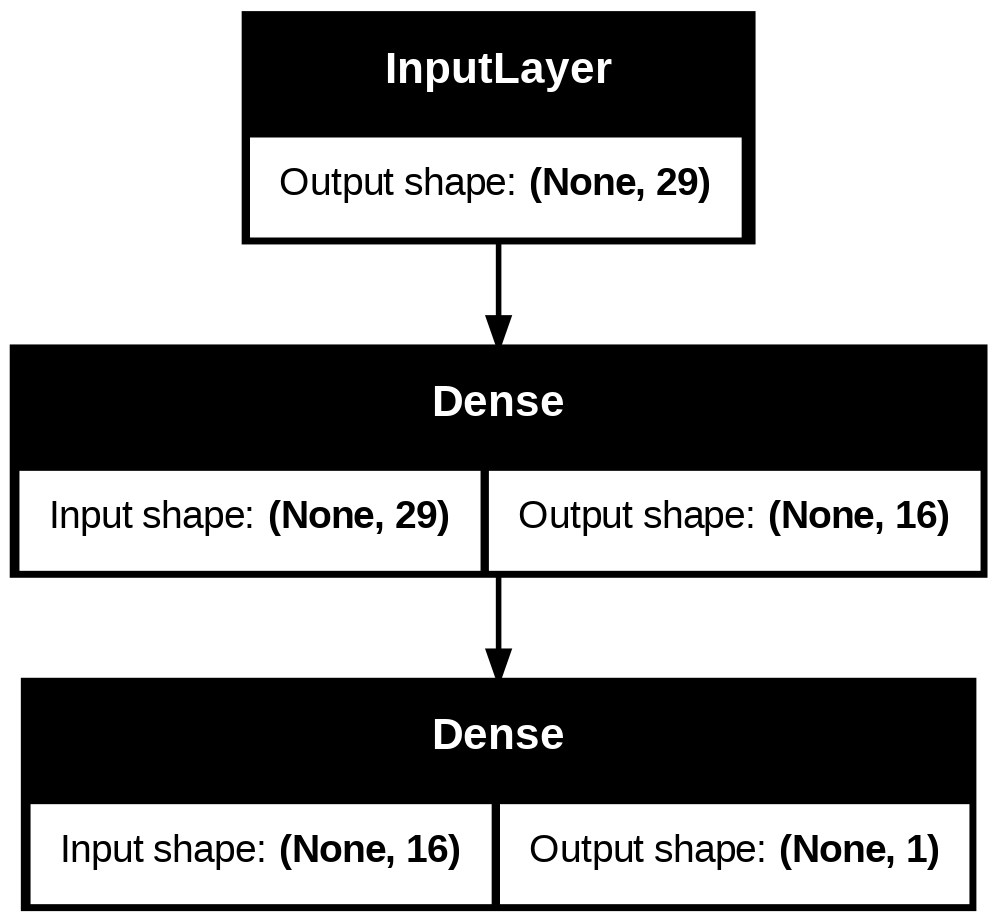

In [25]:
keras.utils.plot_model(model, show_shapes = True)

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:
- What **loss function** to use - Since our output variable is binary, we will select the ``binary_crossentropy`` loss function.
- Which **optimizer** to use - we will use a sibling of **SGD** called $Adam$ which is an excellent default choice.
- What **metrics** you want *Keras* to report out - in classification problems like this one, $Accuracy$ is usually the metric you want to see.

These three choices can be made using the ``model.compile`` function.

In [26]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

So what we do is we tell *Keras*, take the model we just built and compile it with this choice of optimizer($Adam$), this choice of loss function($binary_crossentropy$), and these metrics($Accuracy$).
- And this compilation step, what it does is, essentially $Keras$ will take this information and take the model you've built, and it will reorganize the model in such a way that the parallel computing, distribution of computing across many servers, and so on, that's what's happening in the compile step.
- reorganizing the model so that it becomes amenable to parallelization and distribution, that's what's going on. That's why you actually have to do something called a compile step.
- and once we do that, we finally ready to train the model.

### Train the model


to kickoff training, we have to decide on three things:
- We have to decide what the *batch size* is that we are going to use. and typically what people do is that 32 is a good default for batch size. You can always try 32, 64, 128. we referred to this as a * minibatch*.
- We also have to decide, how many epochs through the data do we want to go through, how many passes through the training data? Usually 20 to 30 epochs is a good starting point. And then, because this is a tiny problem, just for kicks, I just had to run it for 300 epochs, just to see if any overfitting is going to happen.
- And then Whether we want to use a validation set?  Ofcourse, we want to use a validation set. this will be useful for overfitting detection and regularization via early stopping, So we will ask $Keras$ to automatically use 20% of the data points as a validation set, So that we can look for overfitting and underfitting.


## OK,
let's train the model using the ``model.fit`` function!
- ``model.fit`` is what actually trains the neural network.  
- you have to tell it what the $X$ tensor is, **train_X**.
- you have to tell it what the dependent variable $y$ tensor is, **train_y**.
- We need to tell how many **epochs** to do this.
- What the **batch size** to use
- **verbose** = 1 just means put a lot of descriptive output as you do this thing.
- And then **validation_split** means take 20% of the training data and set it aside as your validation dataset. Don't use it for training because I want to measure overfitting using that. The role of **validation** set is to figure out things like Early stopping, "should we stop here, should be go back?"
and as you will see later on, if we use hyperparameters. we will try different values of the hyperparameters and use the **validation** set to figure out which one is the best one.

We will store the output of the training process in ``TP``.

And once we are done with all that, we will finally have a $model$. At that point, we open the safe, take out the **test** set and use it just once with your final $model$.

Not because you want to improve the model, but because you want to have a realistic idea of how it will do when you actually deploy it out in the real world.


In [27]:
TP = model.fit(train_X,                   # the array with the input X columns
               train_y,                   # the aray with the output y column
               epochs= 300,               # how many times to go through the data
               batch_size= 32,            # how many samples to use in each batch
               verbose= 1,                # how many output to see
               validation_split= 0.2)     # use 20% of the data for validation

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.2450 - loss: 1.0514 - val_accuracy: 0.3878 - val_loss: 0.8982
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2103 - loss: 1.0188 - val_accuracy: 0.3878 - val_loss: 0.8535
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2750 - loss: 0.9191 - val_accuracy: 0.4286 - val_loss: 0.8173
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2718 - loss: 0.8899 - val_accuracy: 0.4082 - val_loss: 0.7872
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3560 - loss: 0.8181 - val_accuracy: 0.4286 - val_loss: 0.7593
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3701 - loss: 0.8175 - val_accuracy: 0.5102 - val_loss: 0.7324
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4729 - loss: 0.7556 - val_accuracy: 0.5510 - val_loss: 0.7067
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5012 - loss: 0.7313 - val_accuracy: 0.5510 - val_loss

Now $TP$ object has a lot of information that we can use for plotting and diagnostics and so on.

another object called history ``TP.history``, which is a dictionary with all these values and that's what we're going to plot.


In [28]:
TP_dict = TP.history
TP_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Let's make a little bit of Matplotlib code. what we do is we just plot the training loss and the validation loss as a function of the number of epochs.

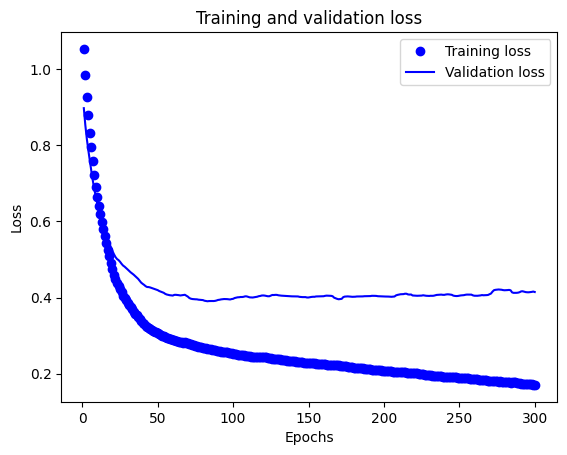

In [29]:
loss_values = TP_dict["loss"]
val_loss_values = TP_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label= "Training loss")
plt.plot(epochs, val_loss_values, "b", label= "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As you can see here, the **Training loss** is steadily going down, as you would expect. The **validation loss** at some point its kind of flatten out and then it gently starts to rise.

#### So do you think there's overfitting?

There seems to be some level of overfitting here.

But the thing you have to always remember is that the ``binary cross-entropy loss`` is a loss function that is convenient for you because it sort of captures the thing you want to capture, the *discrepancy*, but also because it's mathematically convenient. But what you may actually care about in practice is something like **Accuracy**. So we should also plot the accuracy to see what's going on.

And really, you should look at the accuracy and figure out overfitting and all that stuff.

Let's look at the *accuracy* curves as well:

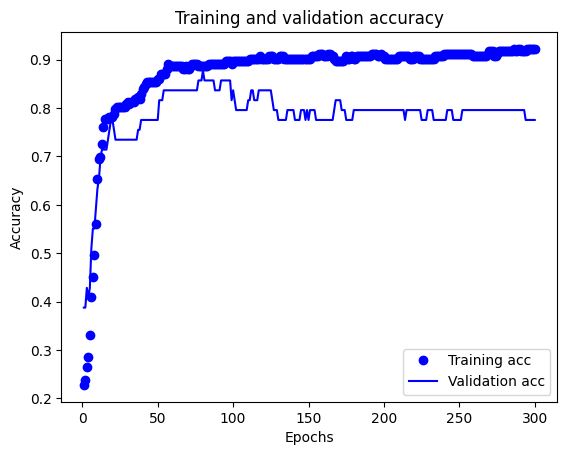

In [30]:
plt.clf()
acc = TP_dict["accuracy"]
val_acc = TP_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label= "Training acc")
plt.plot(epochs, val_acc, "b", label= "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

So i have here overfitting . this is how it looks like for accuracy, as you do more and more epochs, hopefully it gets better and better for training.
- so you can see here accuracy actually climbs all the way up the mid 90s, the Validation gets to this point like 50 epochs maybe and then it flattens out and strangely it climbs up again a bit later.
- Now the fact that *Accuracy* actually got better at the very end suggest that maybe **we can live with this overfitting**
- Around 50 epochs or so, i think that's when it actually flattened out for loss. So you can go back and just restart the model and run it only for 50 epochs, not 300.
- OR, you can say, it's ok I can live with this thing.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
